# Change Detection #

### Author: Angelo Antonio Manzatto ###

-------------------------------------
### Problem ###

Detecting changing areas in videos or sequence of images is an important field in computer vision. Example applications includes:

* Video surveillance
* Anomaly detection 
* Parking occupancy detection
* Object tracking
* Measure traffic flow
* Fall detection
* Patrol national borders

-------------------------------------
### Task ###

Develop a complete solution using Convolutional Neural Networks to extract the background from an image.

The following pipeline was adopted for this project:

* Download selected database from CDNET.
* Create dataset.
* Create data augmentations techniques for pre processing steps.
* Create model (ResNet50 + Decoder)
* Train model.
* Evaluate model.
* Test a batch of samples not previously seen by the model.

-------------------------------------
### Model ###

For this project I used a ResNet model with a peculiar decoder process. Instead of the tradicional Conv2D + UpSampling I used an Average Pooling 3D and a MaxPooling 3D to compress the output channels and then expanded the others using a Conv2D Transposed.

![Resnet Model](images/resnet_model.jpg)

-------------------------------------
### Results ###

![Results](i

-------------------------------------

This project was made using as reference Change Detection Net (CDNET):
Link: http://jacarini.dinf.usherbrooke.ca/
 
Article of Reference:
Y. Wang, P.-M. Jodoin, F. Porikli, J. Konrad, Y. Benezeth, and P. Ishwar, CDnet 2014: 
An Expanded Change Detection Benchmark Dataset, in Proc. IEEE Workshop on Change Detection (CDW-2014) at CVPR-2014, pp. 387-394. 2014

In [1]:
##################################################################################
# Libraries
##################################################################################  
import os
import csv
import requests
import io
import glob
import zipfile

import numpy as np

import matplotlib.pyplot as plt

import cv2

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Model

from keras.layers import Reshape, Lambda, Input,Activation
from keras.layers import Conv2D,  MaxPooling2D, ZeroPadding2D, BatchNormalization, Conv2DTranspose, Add
from keras.layers import AveragePooling3D, MaxPooling3D

from keras.callbacks import ModelCheckpoint, CSVLogger

Using TensorFlow backend.


In [2]:
##################################################################################
# Download Dataset
##################################################################################  

dataset_folder = 'dataset'
database_name = 'turnpike_0_5fps'

# Dataset Link
url = 'http://jacarini.dinf.usherbrooke.ca/static/dataset/lowFramerate/turnpike_0_5fps.zip'   

# Create Dataset folder 
if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

# Donwload dataset if doesn't exist
if not os.path.exists(os.path.join(dataset_folder,database_name)):
    
    # Request files
    r = requests.get(url, allow_redirects=True)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    
    # Extract data to folder
    z.extractall(dataset_folder)

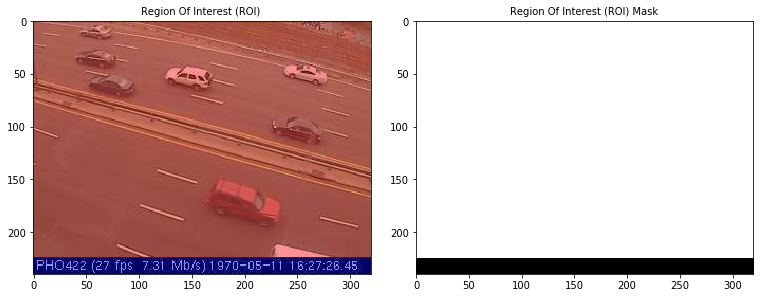

In [3]:
############################################################################################
# Files and folders
############################################################################################
    
# Folders for input images and ground truth images    
input_folder = os.path.join(dataset_folder,database_name,'input')
gt_folder = os.path.join(dataset_folder,database_name,'groundtruth')

# This file defines the index of the images with and withoud a ground truth
temporalROI_file = os.path.join(dataset_folder,database_name,'temporalROI.txt')

f = open(temporalROI_file, "r")
background_idx, roi_idx = f.readline().split()

# Get indexes between just the background images provided for static model and images where we have a ground truth annotation
background_idx = int(background_idx)
roi_idx = int(roi_idx)

# We have just 350 images labeled
roi_images = 350
f.close()

# ROI Masks
roi_file = os.path.join(dataset_folder,database_name,'ROI.jpg')
roi_mask_file = os.path.join(dataset_folder,database_name,'ROI.bmp')

roi_image = plt.imread(roi_file)
roi_mask = plt.imread(roi_mask_file)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
f.tight_layout()
ax1.imshow(roi_image)
ax1.set_title('Region Of Interest (ROI) ', fontsize=10)
ax2.imshow(roi_mask, cmap = 'gray')
ax2.set_title('Region Of Interest (ROI) Mask', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

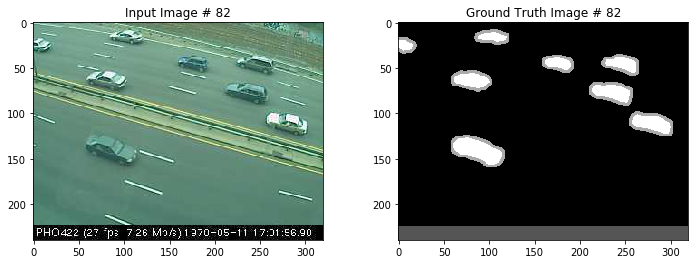

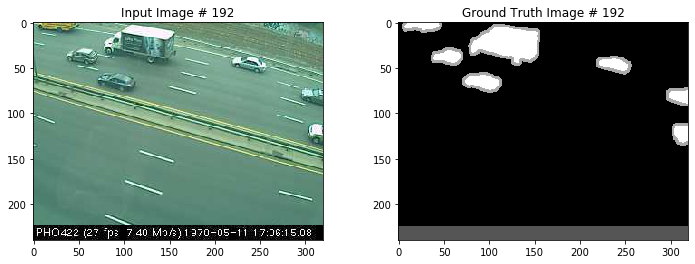

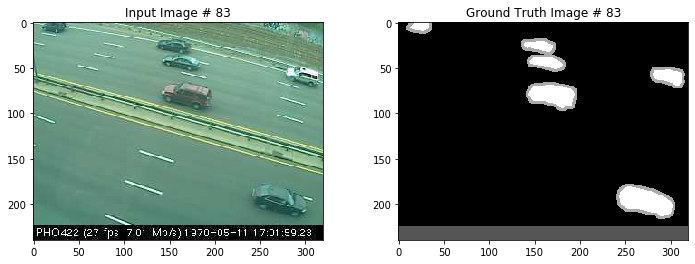

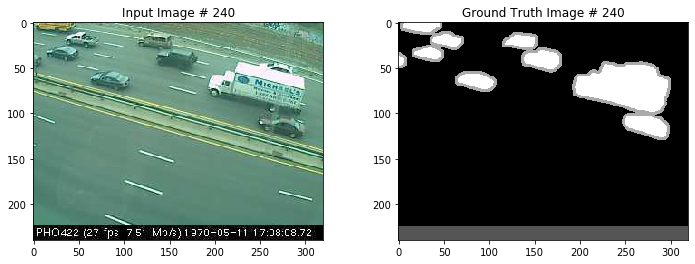

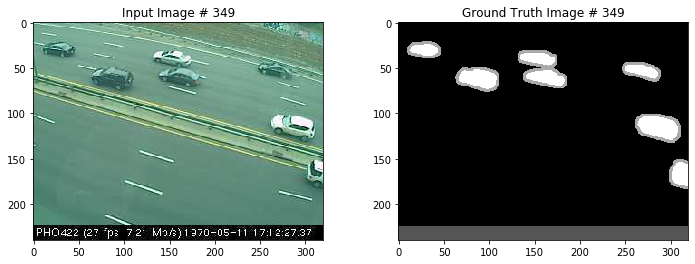

In [4]:
############################################################################################
# Load data
############################################################################################

# image files
input_image_files = glob.glob(os.path.join(input_folder,'*.jpg'))  
gt_image_files = glob.glob(os.path.join(gt_folder,'*.png'))   

# Sort names to avoid connecting wrong numbered files
input_image_files.sort()
gt_image_files.sort()

assert(len(input_image_files) == len(gt_image_files))

# Our dataset is created using the tuple (input image file, ground truth image file)
data = []
for input_image, gt_image in zip(input_image_files,gt_image_files):
    
    data.append((input_image,gt_image))

# This data will be used to create the background model to train the NN
background_data = data[:background_idx-1]

# This data will be used to train / test the model
train_test_data = data[background_idx-1:background_idx-1+roi_images]

# This data will be used to validate the model
valid_data = data[background_idx-1+roi_images:]

# Plot some samples from training set
n_samples = 5

for i in range(n_samples):
    
    # define the size of images
    f, (ax1, ax2) = plt.subplots(1, 2)
    f.set_figwidth(12)
    
    # randomly select a sample
    idx = np.random.randint(0, len(train_test_data))
    input_image_path, gt_image_path = train_test_data[idx]

    input_image = plt.imread(input_image_path)
    gt_image = plt.imread(gt_image_path)
    
    ax1.imshow(input_image)
    ax1.set_title('Input Image # {0}'.format(idx))
    
    ax2.imshow(gt_image)
    ax2.set_title('Ground Truth Image # {0}'.format(idx))

In [5]:
############################################################################################
# Build a background model from a batch of images. We use this to create the static image 
# that will be used to help training the model taking the average value from all files
############################################################################################
def build_background_model(background_data):
    
    n_samples = len(background_data)
    
    bg_image_path, gt_image_path = background_data[0]
    
    first_sample = plt.imread(bg_image_path)
    
    background_model = np.zeros_like(first_sample).astype('float32')
    
    for i in range(n_samples):
        
        bg_image_path, gt_image_path = background_data[i]
        
        sample = plt.imread(bg_image_path)

        background_model += sample
    
    background_model /= n_samples
    
    return background_model.astype('uint8') # Clip to integers of type uint8  

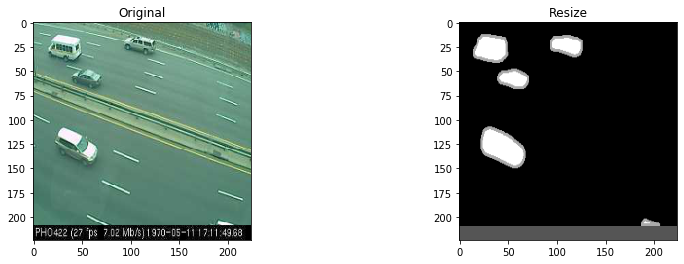

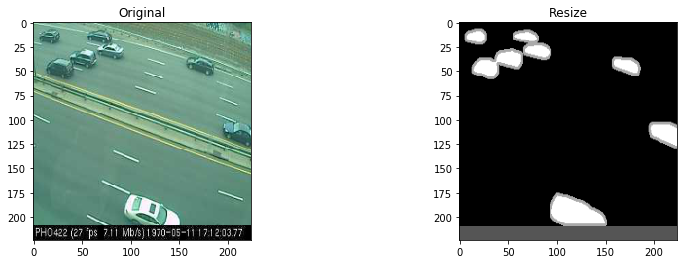

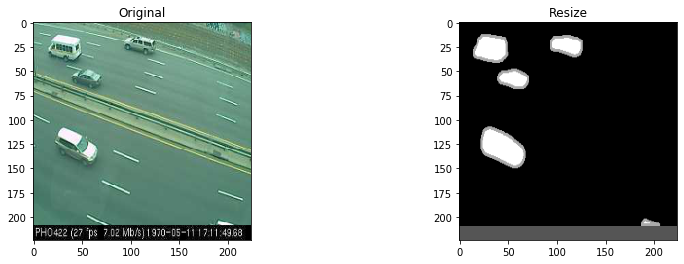

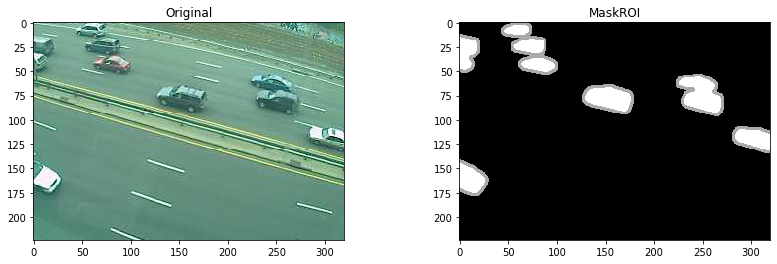

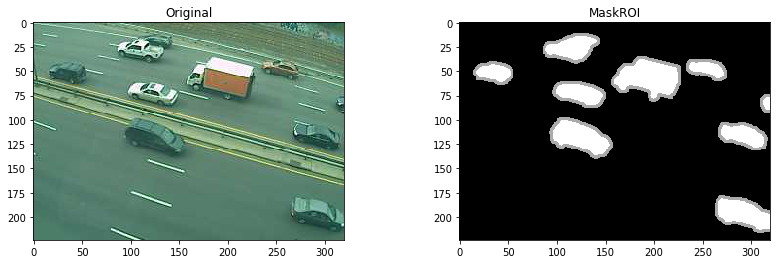

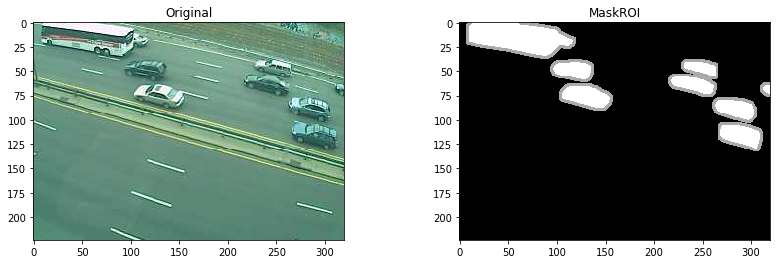

In [6]:
############################################################################################
# Data Augmentation 
############################################################################################
    
#############################
# Resize Image
#############################
class Resize(object):
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        
        # Get image shape
        h, w = image.shape[:2]
        
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
            
        new_h, new_w = int(new_h), int(new_w)

        image = cv2.resize(image, (new_w, new_h))
      
        return image

#############################
# Remove camera data from Image
#############################
class MaskROI(object):
    
    def __init__(self, roi_mask):
        
        mask = roi_mask > 0

        # Coordinates of non-black pixels.
        coords = np.argwhere(mask)
        
        x0, y0 = coords.min(axis=0)
        x1, y1 = coords.max(axis=0)  

        self.x0 = x0
        self.y0 = y0
        self.x1 = x1
        self.y1 = y1+1

    def __call__(self, image):
        
        cropped_image = image[self.x0:self.x1, self.y0:self.y1]
        
        return cropped_image
   
############################################################################################
# Test Data Augmentation 
############################################################################################
def plot_transformation(transformation, n_samples = 3):

    for i in range(n_samples):
    
        # define the size of images
        f, (ax1, ax2) = plt.subplots(1, 2)
        f.set_figwidth(14)

        # randomly select a sample
        idx = np.random.randint(0, len(train_test_data))
        input_image_path, gt_image_path = train_test_data[idx]

        input_image = plt.imread(input_image_path)
        gt_image = plt.imread(gt_image_path)

        new_input_image = transformation(input_image)
        new_gt_image = transformation(gt_image)
        
        if(new_input_image.shape[-1] == 1):
            ax1.imshow(np.squeeze(new_input_image), cmap = 'gray')
        else:
            ax1.imshow(new_input_image)
        ax1.set_title('Original')

        if(new_gt_image.shape[-1] == 1):
            ax2.imshow(np.squeeze(new_gt_image), cmap = 'gray')
        else:
            ax2.imshow(new_gt_image)
        ax2.set_title(type(transformation).__name__)

        plt.show()
        
##########################
# Resize Test
##########################
resize = Resize((224, 224))
plot_transformation(resize)

##########################
# ROI Mask Test
##########################
mask = MaskROI(roi_mask)
plot_transformation(mask)

In [7]:
############################################################################################
# Create Dataset
############################################################################################
    
# Create X, y tuple from image_path, key_pts tuple
def createXy(data, background_image, transformations = None):
    
    input_image_path, gt_image_path = data
    
    input_image = plt.imread(input_image_path)
    gt_image = plt.imread(gt_image_path)
    
    # Apply transformations for the tuple (image, labels, boxes)
    if transformations:
        for t in transformations:
            input_image = t(input_image)
            gt_image  = t(gt_image)
            background_image = t(background_image) 
            
    stacked_image = np.uint8(np.concatenate([input_image,background_image],2))
    
    # Get only one channel since the GT is already in gray scale but with three channels
    gt_image = gt_image[:,:,0]
    gt_image = np.expand_dims(gt_image, axis = -1)         
    
    return stacked_image,gt_image

# Generator for using with model
def generator(data, background_image,  transformations = None, batch_size = 4, shuffle_data= True):
    
    n_samples = len(data)
    
    # Loop forever for the generator
    while 1:
        
        if shuffle_data:
            data = shuffle(data)
        
        for offset in range(0, n_samples, batch_size): 
            
            batch_samples = data[offset:offset + batch_size]
            
            X = []
            y = []
            
            for sample_data in batch_samples:
                
                image, target = createXy(sample_data, background_image, transformations)

                X.append(image)
                y.append(target)
                
            X = np.asarray(X).astype('float32')
            y = np.asarray(y).astype('float32')
            
            yield (shuffle(X, y))

In [8]:
############################################################################################
# Model
############################################################################################

In [9]:
############################################################################################
# ResNet Convolution Block
############################################################################################
def conv_block(inputs, kernel_size, filters, strides, block_id):
    
    f1, f2, f3 = filters
    
    x = Conv2D(f1, kernel_size=(1,1), use_bias=False, kernel_initializer='he_normal', name='block_' + str(block_id) + '_conv_conv2d_1')(inputs)
    x = BatchNormalization(name='block_' + str(block_id) + '_conv_batch_1')(x)
    x = Activation('relu', name='block_' + str(block_id) + '_expand_relu')(x)
    
    x = Conv2D(f2, kernel_size=kernel_size, strides=strides, padding='same', use_bias=False, kernel_initializer='he_normal', name='block_' + str(block_id) + '_conv_conv2d_2')(x)
    x = BatchNormalization(name='block_' + str(block_id) + '_conv_batch_2')(x)
    x = Activation('relu', name='block_' + str(block_id) + '_depthwise_relu')(x)
    
    x = Conv2D(f3, kernel_size=(1,1), use_bias=False, kernel_initializer='he_normal', name='block_' + str(block_id) + '_project_conv2d')(x)
    x = BatchNormalization(name='block_' + str(block_id) + '_project_batch')(x)
    
    shortcut = Conv2D(f3, kernel_size=(1,1), strides=strides, use_bias=False, kernel_initializer='he_normal', name='block_' + str(block_id) + '_shortcut_conv2d')(inputs)
    shortcut = BatchNormalization(name='block_' + str(block_id) + '_shortcut_batch')(x)
    
    x = Add(name='block_' + str(block_id) + '_add')([x, shortcut])
    x = Activation('relu',name='block_' + str(block_id) + '_add_relu')(x)
    
    return x

############################################################################################
# ResNet Identity Block
############################################################################################
def identity_block(inputs,kernel_size, filters, block_id):
    
    f1, f2, f3 = filters
    
    x = Conv2D(f1, kernel_size=(1,1), use_bias=False, kernel_initializer='he_normal', name='block_' + str(block_id) + '_identity_conv2d_1')(inputs)
    x = BatchNormalization(name='block_' + str(block_id) + '_identity_batch_1')(x)
    x = Activation('relu', name='block_' + str(block_id) + '_identity_relu_1')(x)
    
    x = Conv2D(f2, kernel_size = kernel_size, padding='same', use_bias=False, kernel_initializer='he_normal', name='block_' + str(block_id) + '_identity_conv2d_2')(x)
    x = BatchNormalization(name='block_' + str(block_id) + '_identity_batch_2')(x)
    x = Activation('relu',name='block_' + str(block_id) + '_identity_relu_2')(x)
    
    x = Conv2D(f3, kernel_size=(1,1), use_bias=False, kernel_initializer='he_normal', name='block_' + str(block_id) + '_identity_conv2d_3')(x)
    x = BatchNormalization(name='block_' + str(block_id) + '_identity_batch_3')(x)
    
    x = Add(name='block_' + str(block_id) + '_add')([x, inputs])
    x = Activation('relu', name='block_' + str(block_id) + '_identity_relu_3')(x)
    
    return x

def ChangeDetectionNet(input_shape=(224,224,6)):
    
    Image = Input(shape=input_shape)
    Normalize = Lambda(lambda x: x / 255.0 - 0.5)(Image)
    
    ################################
    # Adapter Block to convert from 6 channels to 3
    ################################
    
    encoder = Conv2D(3, kernel_size=(1,1), padding='same', kernel_initializer='he_normal', name='pre_conv')(Normalize)
    
    ################################
    # Block 1
    ################################
    
    encoder = Conv2D(64, kernel_size=(7,7),strides=(2,2), padding='same', kernel_initializer='he_normal', name = 'conv1')(encoder)
    encoder = BatchNormalization(name = 'batch_1')(encoder)
    encoder = Activation('relu',name='relu_1')(encoder)
    encoder = ZeroPadding2D(padding=(1,1), name='zero_pad_1')(encoder)
    encoder = MaxPooling2D(pool_size=(3,3), strides=(2,2), name='max_pool_1')(encoder)
    
    ################################
    # Block 1
    ################################
    encoder = conv_block(encoder, kernel_size=(3,3), filters = [64, 64, 256], strides=(1,1), block_id = 0)
    encoder = identity_block(encoder,kernel_size=(3,3), filters= [64, 64, 256], block_id = 1)
    encoder = identity_block(encoder,kernel_size=(3,3), filters= [64, 64, 256], block_id = 2)
    
    ################################
    # Block 2
    ################################
    encoder = conv_block(encoder, kernel_size=(3,3), filters = [128, 128, 512], strides=(2,2), block_id = 3)
    encoder = identity_block(encoder,kernel_size=(3,3), filters= [128, 128, 512], block_id = 4)
    encoder = identity_block(encoder,kernel_size=(3,3), filters= [128, 128, 512], block_id = 5)
    encoder = identity_block(encoder,kernel_size=(3,3), filters= [128, 128, 512], block_id = 6)
    
    ################################
    # Block 3
    ################################
    encoder = conv_block(encoder, kernel_size=(3,3), filters = [256, 256, 1024], strides=(2,2), block_id = 7)
    encoder = identity_block(encoder,kernel_size=(3,3), filters= [256, 256, 1024], block_id = 8)
    encoder = identity_block(encoder,kernel_size=(3,3), filters= [256, 256, 1024], block_id = 9)
    encoder = identity_block(encoder,kernel_size=(3,3), filters= [256, 256, 1024], block_id = 10)
    encoder = identity_block(encoder,kernel_size=(3,3), filters= [256, 256, 1024], block_id = 11)
    encoder = identity_block(encoder,kernel_size=(3,3), filters= [256, 256, 1024], block_id = 12)
    
    ################################
    # Block 4
    ################################
    encoder = conv_block(encoder, kernel_size = (3,3), filters = [512, 512, 2048], strides=(2,2), block_id = 13)
    encoder = identity_block(encoder,kernel_size= (3,3), filters= [512, 512, 2048], block_id = 14)
    encoder = identity_block(encoder,kernel_size= (3,3), filters= [512, 512, 2048], block_id = 15)
    
    ################################
    # Decode Block 1
    ################################
    
    decoder = Conv2DTranspose(2048,kernel_size=(1,1),strides=(2,2))(encoder)
    decoder = Reshape((14,14,2048,1))(decoder)
    
    decoder = AveragePooling3D(pool_size=(1,1,48),strides=(1,1,40))(decoder)

    decoder = Reshape((14,14,51))(decoder)
    decoder = Conv2DTranspose(32, kernel_size=(3,3),strides=(2,2))(decoder)
    
    decoder = Reshape((29,29,32,1))(decoder)
    decoder = MaxPooling3D(pool_size=(2,2,2),strides=(1,1,2))(decoder)

    decoder = Reshape((28,28,16))(decoder)
    
    # Padding is an important step here unless you want an horrible border effect on the prediction
    decoder = ZeroPadding2D((1,1))(decoder)
    decoder = Conv2DTranspose(8, kernel_size=(2,2),strides=(2,2))(decoder)
    decoder = MaxPooling2D(pool_size=(3,3),strides=(1,1))(decoder)

    decoder = Conv2DTranspose(4, kernel_size=(2,2),strides=(2,2))(decoder)
    decoder = MaxPooling2D(pool_size=(3,3),strides=(1,1))(decoder)
    
    decoder = Conv2DTranspose(1, kernel_size=(2,2),strides=(2,2))(decoder)
    decoder = MaxPooling2D(pool_size=(3,3),strides=(1,1))(decoder)
    
    decoder = Conv2D(1,kernel_size=(1,1),strides=(1,1), activation='sigmoid')(decoder)
    decoder = MaxPooling2D(pool_size=(3,3),strides=(1,1))(decoder)
    
    model = Model(inputs=Image,outputs=decoder)

    return model

In [10]:
############################################################################################
# Training pipeline
############################################################################################

# Data augmentation 
train_transformations = [
        MaskROI(roi_mask),
        Resize((224,224))
        ]

test_transformations = [
        MaskROI(roi_mask),
        Resize((224,224))
        ]

valid_transformations = [
        MaskROI(roi_mask),
        Resize((224,224))
        ]

# Hyperparameters
epochs = 200
batch_size = 4 # Change this value if you have more GPU Power
learning_rate = 0.001
weight_decay = 5e-4
momentum = .9

train_data, test_data = train_test_split(train_test_data, test_size=0.20, random_state=42)

background_image = build_background_model(background_data)

train_generator = generator(train_data, background_image, train_transformations, batch_size)
test_generator = generator(test_data, background_image, test_transformations, batch_size)

# callbacks
model_path = 'saved_models'

# File were the best model will be saved during checkpoint     
model_file = os.path.join(model_path,'change_detection-{val_loss:.4f}.h5')

# Check point for saving the best model
check_pointer = ModelCheckpoint(model_file, monitor='val_loss', mode='min',verbose=1, save_best_only=True)

# Logger to store loss on a csv file
csv_logger = CSVLogger(filename='change_detection.csv',separator=',', append=True)

model = ChangeDetectionNet()
model.compile(optimizer='adam',loss='binary_crossentropy', metrics = ['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 6)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 224, 224, 6)  0           input_1[0][0]                    
__________________________________________________________________________________________________
pre_conv (Conv2D)               (None, 224, 224, 3)  21          lambda_1[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        pre_conv[0][0]                   
__________________________________________________________________________________________________
batch_1 (B

In [11]:
history = model.fit_generator(train_generator,steps_per_epoch=int(len(train_data) / batch_size),
                              validation_data=test_generator,validation_steps=int(len(test_data) / batch_size),
                              epochs=epochs, verbose=1, callbacks=[check_pointer,csv_logger],workers=1)

Epoch 1/200
70/70 [==============================] - 94s 1s/step - loss: 0.4744 - acc: 0.8055 - val_loss: 0.4340 - val_acc: 0.8926

Epoch 00001: val_loss improved from inf to 0.43405, saving model to saved_models\change_detection-0.4340.h5
Epoch 2/200
70/70 [==============================] - 78s 1s/step - loss: 0.1863 - acc: 0.8874 - val_loss: 0.2154 - val_acc: 0.8906

Epoch 00002: val_loss improved from 0.43405 to 0.21538, saving model to saved_models\change_detection-0.2154.h5
Epoch 3/200
70/70 [==============================] - 77s 1s/step - loss: 0.1532 - acc: 0.9040 - val_loss: 0.1508 - val_acc: 0.9193

Epoch 00003: val_loss improved from 0.21538 to 0.15082, saving model to saved_models\change_detection-0.1508.h5
Epoch 4/200
70/70 [==============================] - 77s 1s/step - loss: 0.1157 - acc: 0.9368 - val_loss: 0.2110 - val_acc: 0.9098

Epoch 00004: val_loss did not improve from 0.15082
Epoch 5/200
70/70 [==============================] - 77s 1s/step - loss: 0.0951 - acc: 0.


Epoch 00039: val_loss did not improve from 0.04751
Epoch 40/200
70/70 [==============================] - 78s 1s/step - loss: 0.0474 - acc: 0.9555 - val_loss: 0.0518 - val_acc: 0.9537

Epoch 00040: val_loss did not improve from 0.04751
Epoch 41/200
70/70 [==============================] - 78s 1s/step - loss: 0.0445 - acc: 0.9561 - val_loss: 0.0510 - val_acc: 0.9543

Epoch 00041: val_loss did not improve from 0.04751
Epoch 42/200
70/70 [==============================] - 78s 1s/step - loss: 0.0428 - acc: 0.9566 - val_loss: 0.0494 - val_acc: 0.9545

Epoch 00042: val_loss did not improve from 0.04751
Epoch 43/200
70/70 [==============================] - 78s 1s/step - loss: 0.0422 - acc: 0.9567 - val_loss: 0.0452 - val_acc: 0.9567

Epoch 00043: val_loss improved from 0.04751 to 0.04522, saving model to saved_models\change_detection-0.0452.h5
Epoch 44/200
70/70 [==============================] - 77s 1s/step - loss: 0.0413 - acc: 0.9570 - val_loss: 0.0493 - val_acc: 0.9554

Epoch 00044: val_l


Epoch 00083: val_loss did not improve from 0.04411
Epoch 84/200
70/70 [==============================] - 77s 1s/step - loss: 0.0371 - acc: 0.9579 - val_loss: 0.0473 - val_acc: 0.9556

Epoch 00084: val_loss did not improve from 0.04411
Epoch 85/200
70/70 [==============================] - 77s 1s/step - loss: 0.0373 - acc: 0.9579 - val_loss: 0.0478 - val_acc: 0.9561

Epoch 00085: val_loss did not improve from 0.04411
Epoch 86/200
70/70 [==============================] - 77s 1s/step - loss: 0.0375 - acc: 0.9578 - val_loss: 0.0470 - val_acc: 0.9547

Epoch 00086: val_loss did not improve from 0.04411
Epoch 87/200
70/70 [==============================] - 77s 1s/step - loss: 0.0373 - acc: 0.9578 - val_loss: 0.0477 - val_acc: 0.9550

Epoch 00087: val_loss did not improve from 0.04411
Epoch 88/200
70/70 [==============================] - 77s 1s/step - loss: 0.0377 - acc: 0.9578 - val_loss: 0.0492 - val_acc: 0.9530

Epoch 00088: val_loss did not improve from 0.04411
Epoch 89/200
70/70 [========

70/70 [==============================] - 77s 1s/step - loss: 0.0357 - acc: 0.9581 - val_loss: 0.0484 - val_acc: 0.9541

Epoch 00128: val_loss did not improve from 0.04411
Epoch 129/200
70/70 [==============================] - 77s 1s/step - loss: 0.0357 - acc: 0.9581 - val_loss: 0.0470 - val_acc: 0.9551

Epoch 00129: val_loss did not improve from 0.04411
Epoch 130/200
70/70 [==============================] - 77s 1s/step - loss: 0.0356 - acc: 0.9581 - val_loss: 0.0463 - val_acc: 0.9557

Epoch 00130: val_loss did not improve from 0.04411
Epoch 131/200
70/70 [==============================] - 77s 1s/step - loss: 0.0356 - acc: 0.9581 - val_loss: 0.0475 - val_acc: 0.9547

Epoch 00131: val_loss did not improve from 0.04411
Epoch 132/200
70/70 [==============================] - 77s 1s/step - loss: 0.0358 - acc: 0.9581 - val_loss: 0.0439 - val_acc: 0.9575

Epoch 00132: val_loss improved from 0.04411 to 0.04389, saving model to saved_models\change_detection-0.0439.h5
Epoch 133/200
70/70 [=======

70/70 [==============================] - 78s 1s/step - loss: 0.0352 - acc: 0.9581 - val_loss: 0.0471 - val_acc: 0.9559

Epoch 00172: val_loss did not improve from 0.04389
Epoch 173/200
70/70 [==============================] - 78s 1s/step - loss: 0.0353 - acc: 0.9581 - val_loss: 0.0470 - val_acc: 0.9544

Epoch 00173: val_loss did not improve from 0.04389
Epoch 174/200
70/70 [==============================] - 78s 1s/step - loss: 0.0353 - acc: 0.9581 - val_loss: 0.0457 - val_acc: 0.9559

Epoch 00174: val_loss did not improve from 0.04389
Epoch 175/200
70/70 [==============================] - 78s 1s/step - loss: 0.0350 - acc: 0.9582 - val_loss: 0.0493 - val_acc: 0.9544

Epoch 00175: val_loss did not improve from 0.04389
Epoch 176/200
70/70 [==============================] - 78s 1s/step - loss: 0.0351 - acc: 0.9581 - val_loss: 0.0449 - val_acc: 0.9561

Epoch 00176: val_loss did not improve from 0.04389
Epoch 177/200
70/70 [==============================] - 78s 1s/step - loss: 0.0349 - acc: 

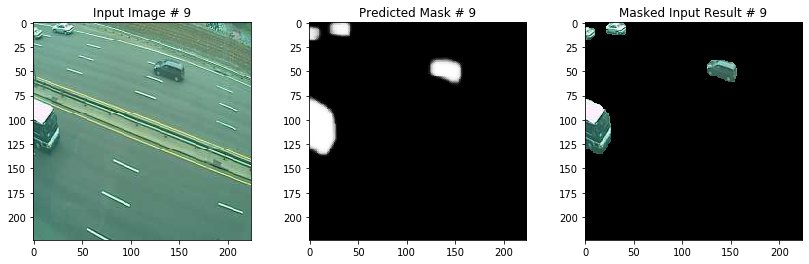

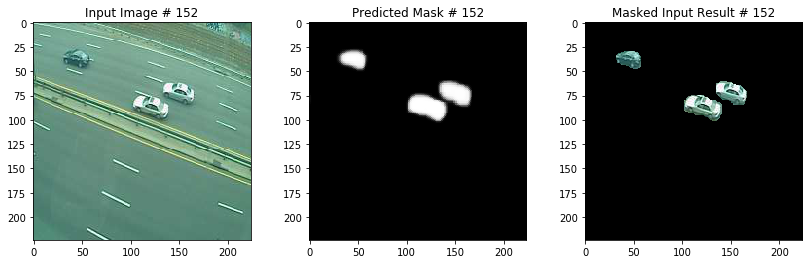

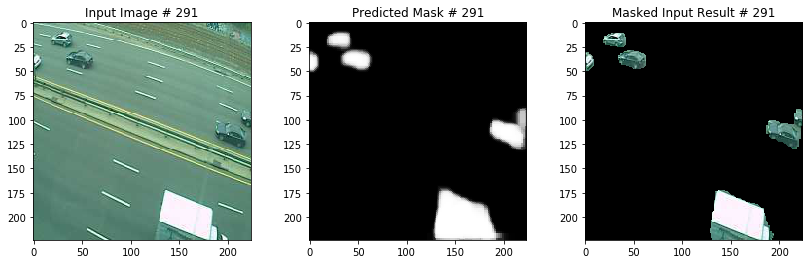

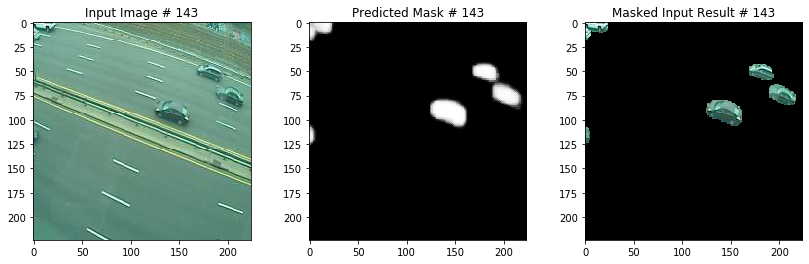

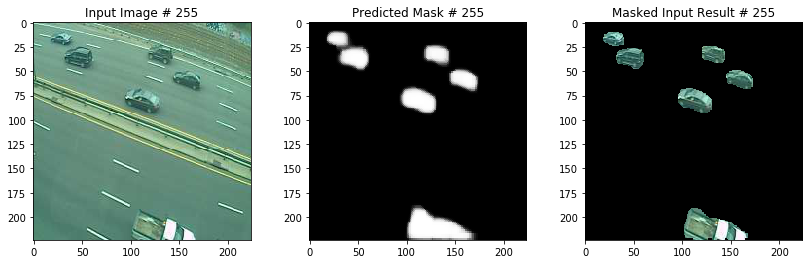

In [27]:
############################################################################################
# Predict
############################################################################################

# If we want to test on a pre trained model use the following line
# model.load_weights(os.path.join(model_path,'<path to model>'), by_name=False)

n_samples = 5

for i in range(n_samples):
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    f.set_figwidth(14)
    
    # randomly select a sample
    idx = np.random.randint(0, len(valid_data))
    sample = valid_data[idx]
    
    # Read input file
    input_image_path, gt_image_path = sample
    input_image = plt.imread(input_image_path)
    
    input_image_copy = np.copy(input_image)
    background_image_copy = np.copy(background_image)

    # Apply transformations to input and background image
    for t in valid_transformations:
        input_image_copy = t(input_image_copy)
        background_image_copy = t(background_image_copy)
        
    # Stack images to compose the input for model [H, W, 6]
    stacked_image = np.uint8(np.concatenate([input_image_copy,background_image_copy],2))

    # Predict 
    mask_pred = model.predict(stacked_image[np.newaxis,...]) 
    
    # Squeeze
    mask_pred = np.squeeze(mask_pred[0])
    
    # Plot 
    ax1.set_title('Input Image # {0}'.format(idx))
    ax1.imshow(input_image_copy.astype('uint8'))
    
    ax2.set_title('Predicted Mask # {0}'.format(idx))
    ax2.imshow(mask_pred, cmap='gray')
    
    mask_pred[mask_pred > 0.5] = 1.0
    mask_pred[mask_pred <= 0.5] = 0.0
    
    combined_image = np.copy(input_image_copy)
    combined_image[mask_pred == 0] = 0
    
    ax3.set_title('Masked Input Result # {0}'.format(idx))
    ax3.imshow(combined_image)

In [28]:
############################################################################################
# Evaluate our model
############################################################################################

mask = MaskROI(roi_mask)

measures = np.zeros((len(train_test_data),11))
statistics = []
    
for i, sample in enumerate(train_test_data):
    
    # Retrieve tuple
    input_image_path, gt_image_path = sample
    
    print("input: {0} , gt: {1}".format(input_image_path.split("\\")[-1],gt_image_path.split("\\")[-1]))
    
    # Read input file
    input_image = plt.imread(input_image_path)
    gt_image = plt.imread(gt_image_path)
    
    # Make a copy for safety
    input_image_copy = np.copy(input_image)
    background_image_copy = np.copy(background_image)
    gt_image_copy = np.copy(gt_image)
    
    # Apply transformations to input and background image. This time we will not use the ground truth image 
    # in the transformation step since we want to evaluate against the original data excluding the mask
    for t in valid_transformations:
        input_image_copy = t(input_image_copy)
        background_image_copy = t(background_image_copy)

    # Just remove the lower border of camera data
    y_true = mask(gt_image_copy)
    y_true = y_true[:,:,0]
    
    # Stack images to compose the input for model [H, W, 6]
    X = np.uint8(np.concatenate([input_image_copy,background_image_copy],2))
    
    # Predict the mask using the model
    y_pred = model.predict(stacked_image[np.newaxis,...]) 
    
    # Remove sinle dimensions
    y_pred = np.squeeze(y_pred)
    
    # Resize output from model to original size from the ground truth
    w,h = y_true.shape[:2]
    resize = Resize((w,h))
    y_pred = resize(y_pred)
    
    # Apply threshold value where we consider the predicted pixel as 1 and 0
    y_pred[y_pred > 0.5] = 1.0
    y_pred[y_pred <= 0.5] = 0.0
    
    y_true[y_true > 0.5] = 1.0
    y_true[y_true <= 0.5] = 0.0
        
    # Calculate True Positive, True Negative, False Positive, False Negative
    TP = np.sum(np.logical_and(y_pred == 1, y_true == 1))
    TN = np.sum(np.logical_and(y_pred == 0, y_true == 0))
    FP = np.sum(np.logical_and(y_pred == 1, y_true == 0))
    FN = np.sum(np.logical_and(y_pred == 0, y_true == 1))

    # Calculate Recall
    recall = TP / (TP + FN)
    
    # Calculate Specificity
    specificity =  TN / (TN + FP)
    
    # Calculate False Positive Rate
    FPR =  FP / (FP + TN)
    
    # Calculate False Negative Rate
    FNR = FN / (TP + FN)
    
    # Calculate Percentage of Wrong Classifications
    PWC =  100 * (FN + FP) / (TP + FN + FP + TN)

    # Calculate Precision
    precision =  TP / (TP + FP)
    
    # Calculate f measure
    f_measure = (2 * precision * recall) / (precision + recall)
    
    stats = { 'input_image': input_image_path,
              'gt_image' : gt_image_path,
              'TP' : TP,
              'TN' : TN,
              'FP' : FP,
              'FN' : FN,
              'recall' : recall,
              'specificity' : specificity,
              'FPR' : FPR,
              'FNR' : FNR,
              'PWC' : PWC,
              'precision' : precision,
              'f_measure' : f_measure
            }
    
    statistics.append(stats)
    
    measures[i][0] = TP
    measures[i][1] = TN
    measures[i][2] = FP
    measures[i][3] = FN
    measures[i][4] = recall
    measures[i][5] = specificity
    measures[i][6] = FPR
    measures[i][7] = FNR
    measures[i][8] = PWC
    measures[i][9] = precision
    measures[i][10] = f_measure

input: in000800.jpg , gt: gt000800.png
input: in000801.jpg , gt: gt000801.png
input: in000802.jpg , gt: gt000802.png
input: in000803.jpg , gt: gt000803.png
input: in000804.jpg , gt: gt000804.png
input: in000805.jpg , gt: gt000805.png
input: in000806.jpg , gt: gt000806.png
input: in000807.jpg , gt: gt000807.png
input: in000808.jpg , gt: gt000808.png
input: in000809.jpg , gt: gt000809.png
input: in000810.jpg , gt: gt000810.png
input: in000811.jpg , gt: gt000811.png
input: in000812.jpg , gt: gt000812.png
input: in000813.jpg , gt: gt000813.png
input: in000814.jpg , gt: gt000814.png
input: in000815.jpg , gt: gt000815.png
input: in000816.jpg , gt: gt000816.png
input: in000817.jpg , gt: gt000817.png
input: in000818.jpg , gt: gt000818.png
input: in000819.jpg , gt: gt000819.png
input: in000820.jpg , gt: gt000820.png
input: in000821.jpg , gt: gt000821.png
input: in000822.jpg , gt: gt000822.png
input: in000823.jpg , gt: gt000823.png
input: in000824.jpg , gt: gt000824.png
input: in000825.jpg , gt:

input: in001010.jpg , gt: gt001010.png
input: in001011.jpg , gt: gt001011.png
input: in001012.jpg , gt: gt001012.png
input: in001013.jpg , gt: gt001013.png
input: in001014.jpg , gt: gt001014.png
input: in001015.jpg , gt: gt001015.png
input: in001016.jpg , gt: gt001016.png
input: in001017.jpg , gt: gt001017.png
input: in001018.jpg , gt: gt001018.png
input: in001019.jpg , gt: gt001019.png
input: in001020.jpg , gt: gt001020.png
input: in001021.jpg , gt: gt001021.png
input: in001022.jpg , gt: gt001022.png
input: in001023.jpg , gt: gt001023.png
input: in001024.jpg , gt: gt001024.png
input: in001025.jpg , gt: gt001025.png
input: in001026.jpg , gt: gt001026.png
input: in001027.jpg , gt: gt001027.png
input: in001028.jpg , gt: gt001028.png
input: in001029.jpg , gt: gt001029.png
input: in001030.jpg , gt: gt001030.png
input: in001031.jpg , gt: gt001031.png
input: in001032.jpg , gt: gt001032.png
input: in001033.jpg , gt: gt001033.png
input: in001034.jpg , gt: gt001034.png
input: in001035.jpg , gt:

--------------------------------------------------
Recal: Avg:0.12 , Max: 0.39 , Min: 0.00
--------------------------------------------------
Specificity: Avg:0.93 , Max: 0.97 , Min: 0.91
--------------------------------------------------
False Positive Rate: Avg:0.07 , Max: 0.09 , Min: 0.03
--------------------------------------------------
Calculate False Negative Rate: Avg:0.88 , Max: 1.00 , Min: 0.61
--------------------------------------------------
Percentage of Wrong Classifications: Avg:15.48 , Max: 37.97 , Min: 8.15
--------------------------------------------------
Precision: Avg:0.18 , Max: 0.68 , Min: 0.00
--------------------------------------------------
F-Measure: Avg:0.14 , Max: 0.41 , Min: 0.00
--------------------------------------------------
--------------------------------------------------
Confusion Matrix
--------------------------------------------------


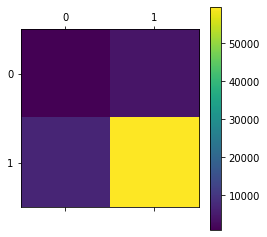

In [30]:
# Replace NaN by zeros
measures[np.isnan(measures)] = 0

# Calculate Mean Average for all our statistics
mean_score = measures.mean(axis=0)
max_score = measures.max(axis=0)
min_score = measures.min(axis=0)

# Print Average Statistics
print(50*'-')
print('Recal: Avg:{0:.2f} , Max: {1:.2f} , Min: {2:.2f}'.format(mean_score[4],max_score[4],min_score[4]))
print(50*'-')
print('Specificity: Avg:{0:.2f} , Max: {1:.2f} , Min: {2:.2f}'.format(mean_score[5],max_score[5],min_score[5]))
print(50*'-')
print('False Positive Rate: Avg:{0:.2f} , Max: {1:.2f} , Min: {2:.2f}'.format(mean_score[6],max_score[6],min_score[6]))
print(50*'-')
print('Calculate False Negative Rate: Avg:{0:.2f} , Max: {1:.2f} , Min: {2:.2f}'.format(mean_score[7],max_score[7],min_score[7]))
print(50*'-')
print('Percentage of Wrong Classifications: Avg:{0:.2f} , Max: {1:.2f} , Min: {2:.2f}'.format(mean_score[8],max_score[8],min_score[8]))
print(50*'-')
print('Precision: Avg:{0:.2f} , Max: {1:.2f} , Min: {2:.2f}'.format(mean_score[9],max_score[9],min_score[9]))
print(50*'-')
print('F-Measure: Avg:{0:.2f} , Max: {1:.2f} , Min: {2:.2f}'.format(mean_score[10],max_score[10],min_score[10]))
print(50*'-')

# Create Confusion Matrix
cm = np.zeros((2,2))
cm[0][0] = mean_score[0]
cm[0][1] = mean_score[2]
cm[1][0] = mean_score[3]
cm[1][1] = mean_score[1]

print(50*'-')
print('Confusion Matrix')
plt.matshow(cm)
plt.colorbar()
print(50*'-')

In [32]:
# Save results on a file
results_folder = 'results'

# Create Dataset folder 
if not os.path.exists(results_folder):
    os.makedirs(results_folder)
    
csv_columns = ['input_image','gt_image','TP','TN','FP','FN','recall','specificity','FPR','FNR','PWC','precision','f_measure']

csv_file = os.path.join(results_folder,database_name + '_stats.csv')

try:
    with open(csv_file, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=csv_columns, lineterminator = '\n')
        writer.writeheader()
        for data in statistics:
            writer.writerow(data)
except IOError:
    print("I/O error") 

In [23]:
############################################################################################
# Video Testing
############################################################################################    
from moviepy.editor import ImageClip, concatenate

video_folder = 'videos'   

clips = []

for sample in valid_data:
    
    input_image_path, gt_image_path = sample
    
    # Read input file
    input_image_path, gt_image_path = sample
    input_image = plt.imread(input_image_path)
    
    input_image_copy = np.copy(input_image)
    background_image_copy = np.copy(background_image)

    # Apply transformations to input and background image
    for t in valid_transformations:
        input_image_copy = t(input_image_copy)
        background_image_copy = t(background_image_copy)
        
    # Stack images to compose the input for model [H, W, 6]
    stacked_image = np.uint8(np.concatenate([input_image_copy,background_image_copy],2))

    # Predict 
    mask_pred = model.predict(stacked_image[np.newaxis,...]) 
    
    # Squeeze
    mask_pred = np.squeeze(mask_pred[0])
    mask_pred[mask_pred > 0.5] = 1.0
    mask_pred[mask_pred <= 0.5] = 0.0
    
    combined_image = np.copy(input_image_copy)
    combined_image[mask_pred == 0] = 0
        
    combined_image = cv2.resize(combined_image,(320 ,320))
    resized_input_image = cv2.resize(input_image_copy,(320 ,320))
    
    stacked_image = np.hstack((resized_input_image, combined_image))
        
    clips.append(ImageClip(stacked_image).set_duration(1))

video = concatenate(clips, method="compose")
video.write_videofile(os.path.join(video_folder,'test_video.mp4'), fps=24)

[MoviePy] >>>> Building video videos\test_video.mp4
[MoviePy] Writing video videos\test_video.mp4


100%|████████████████████████████████████████████████████████████████████████████▉| 8424/8425 [00:47<00:00, 177.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos\test_video.mp4 



<div style="text-align:center">
    <img src="images/change_detection.gif" alt="Change Detection Test"/>
</div>